<p style="font-size:20px">제조데이터 준비 [사용대상: 표면처리 뿌리업종 내 아연도금 산출물에서 발생하는 이미지 제조데이터(Vision Machine 활용)]</p>

<p style="font-size:20px">제조물 : 배관용 L자 연결 파이프(L자 관이음쇠) 아연도금</p>

<p style="font-size:20px">현장문제: 공정시 산출물로 나오게 되는 L자 관이음쇠의 외관 품질 상태를 작업자가 하나하나 눈으로 체크하고 있으며, 이로 인한 노동력 낭비가 발생하고 있음</p>

<p style="font-size:20px">제조AI 개발 목적: 비전 시스템을 활용하여 표면처리(아연도금) 산출물의 외관 품질 검사를 자동화하고, 분류할 수 있게 하기 위함</p>

# Library Install

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install seaborn
# !pip install tensorflow
# !pip install datetime
# !pip install matplotlib
# !pip install pydot
# !pip install graphviz

# Library Import

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import glob
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# Training Validation Tool Import
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [4]:
# Deep Learning Framework Import
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')  # Set GPU Use

In [6]:
# GPU Use, not in condition -> Error
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # Set GPU Memory Useage Growth
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')   # Set Logical GPU
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")   # Print GPU Info
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
# Image Preprocessing
def img_preprocess(img):
    img = Image.open(img)   # Open Image
    img = img.convert('RGB')   # Image Color Channel Change BGR->RGB
    img = img.resize((256,256))   # Image Resize for training
    img = np.asarray(img)/255   # Image Normalization
    return img  # return Image

In [8]:
class AutoImageClassification:
    def __init__(self, path):
        self.train_df = self._create_df(path, '\학습')  # Training DataFrame Set
        self.test_df = self._create_df(path, '\테스트') # Test DataFrame Set
        
    @staticmethod
    def _create_df(path, path2):    # Make DataFrame for Training / Test
        files1 = glob.glob(path+path2+"\정상\*.png")    # Get Images from True Image Folder
        files2 = glob.glob(path+path2+"\불량\*.png")    # Get Images from False Image Folder
        df_n = pd.DataFrame()   # Initialize DataFrame for False
        df_p = pd.DataFrame()   # Initialize DataFrame for True
        df_n['name'] = [x for x in files2]  # False Image Name Insert into DataFrame's column name
        df_n['outcome'] = 0.      # False Image Value Insert into DataFrame's column outcome
        df_p['name'] = [x for x in files1]  # True Image Name Insert into DataFrame's column name
        df_p['outcome'] = 1.      # True Image Value Insert into DataFrame's column outcome
        df = pd.concat([df_n, df_p], axis = 0, ignore_index = True)  # Concat True / False Dataframe
        df = shuffle(df)        # Shuffle DataFame Rows
        return df
    
    def create_x_and_y(self):   # Get Data Pair (Image, Value)
        X = np.array([img_preprocess(p) for p in self.train_df.name.values])    # Get Image Data
        y = self.train_df.outcome.values    # Get Value Data from DataFrame
        return X, y

In [9]:
aic = AutoImageClassification(path = os.getcwd())   # Initizlie AIC Class

In [10]:
is_training = True # Set Training Trigger

In [11]:
if is_training: # if Training Trigger True, Do underline
        X, y = aic.create_x_and_y()     # Get Training Datas

In [12]:
def modelGen():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
if is_training: # if Training Trigger True, Do Training
    model = modelGen()
    model.fit(x=X, y=y, epochs=3, validation_split=0.2, verbose=2)  # Model Training
    model.save('trainedModel.h5')    # Model Export
else:
    model = tf.keras.models.load_model("trainedModel.h5") # Get Trained Model

Epoch 1/3
29/29 - 7s - loss: 0.3776 - accuracy: 0.9246 - val_loss: 0.0934 - val_accuracy: 0.9700 - 7s/epoch - 238ms/step
Epoch 2/3
29/29 - 2s - loss: 0.0825 - accuracy: 0.9741 - val_loss: 0.0638 - val_accuracy: 0.9828 - 2s/epoch - 70ms/step
Epoch 3/3
29/29 - 2s - loss: 0.0469 - accuracy: 0.9871 - val_loss: 0.0226 - val_accuracy: 0.9914 - 2s/epoch - 69ms/step


In [14]:
model.summary() # Model Shape Showing

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [15]:
plot_model(model)   # Model Architecture Showing

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
x_test = np.array([img_preprocess(p) for p in aic.test_df.name.values]) # Get Test Images
y_test = aic.test_df.outcome.values # Get Test Values

In [17]:
y_pred_ori = model.predict(x_test)  # Model Inference
y_pred = [round(y[0], 0) for y in y_pred_ori]   # Round Predict Values
print("accuracy  = ", accuracy_score(y_test, y_pred))   # Print Model Accuracy with Test Data
print("recall    = ", recall_score(y_test, y_pred))     # Print Model Recall with Test Data
print("precision = ", precision_score(y_test, y_pred))  # Print Model Score with Test Data
print("f1 score  = ", f1_score(y_test, y_pred))         # Print Model F1-Score with Test Data

10/10 [==============================] - 1s 48ms/step
accuracy  =  0.9965635738831615
recall    =  1.0
precision =  0.9963898916967509
f1 score  =  0.9981916817359855


(array([ 14.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 276.]),
 array([9.88007287e-07, 9.99992192e-02, 1.99997455e-01, 2.99995691e-01,
        3.99993926e-01, 4.99992162e-01, 5.99990368e-01, 6.99988604e-01,
        7.99986839e-01, 8.99985075e-01, 9.99983311e-01]),
 <BarContainer object of 10 artists>)

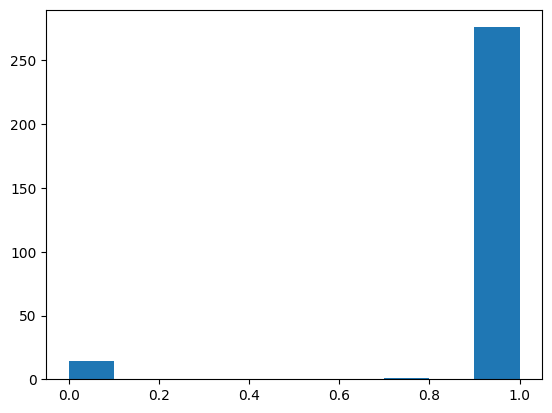

In [18]:
plt.hist(y_pred_ori)    # Predict Value Plot

In [19]:
print('Keras Model Predict : ', y_pred) # Print Predict Values
rmse = sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE Value with Predict Values and Real Values
print('Keras Model RMS : ', rmse)   # Print RMSE Value

Keras Model Predict :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)    # Calculate ROC Curve Data
print(fpr, tpr, thresholds)                         # Print ROC Curve Data

[0.         0.06666667 1.        ] [0. 1. 1.] [2. 1. 0.]


In [21]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0])   # Calculate Confusion Matrix Data
print(conf_matrix)                                              # Print Confusion Matrix Data

[[276   0]
 [  1  14]]


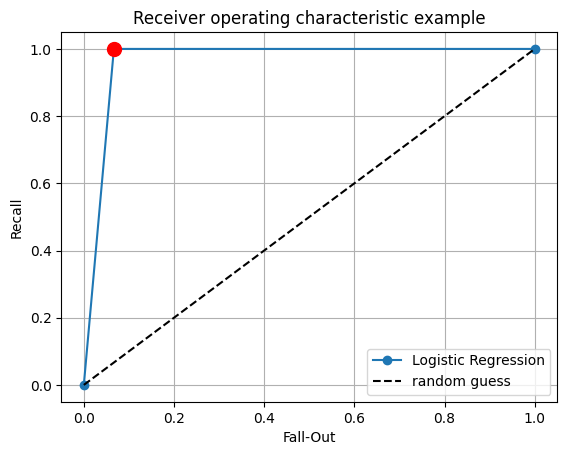

In [22]:
recall = conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1])    # Calculate Recall Value from Confusion Matrix Data
fallout = conf_matrix[1][0]/(conf_matrix[1][0]+conf_matrix[1][1])   # Calculate Fallout Value from Confusion Matrix Data
plt.plot(fpr, tpr, 'o-', label="Logistic Regression")               # plot ROC Curve Data
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)                          # plot Fallout Data
plt.xlabel('Fall-Out')                                              # Set x Label
plt.ylabel('Recall')                                                # Set y Label
plt.title('Receiver operating characteristic example')              # Set Title
plt.grid()                                                          # Set Grid
plt.legend()                                                        # Set Legend
plt.show()                                                          # Show Plot Image

In [23]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))   # Print Report

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.97        15
     class 1       1.00      1.00      1.00       276

    accuracy                           1.00       291
   macro avg       1.00      0.97      0.98       291
weighted avg       1.00      1.00      1.00       291

